### Data Description(https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat)

id - 각 영화의 고유 ID(정수)

belongs_to_collection - JSON 형식의 영화의 TMDB ID, 이름, 영화 포스터, 배경 URL. 포스터와 배경 이미지를 볼 수 있다.

budget : 영화 예산(달러). 0은 알 수 없음을 의미

genres : JSON 형식의 모든 장르, 이름, TMDB ID

homepage - 영화의 공식 홈페이지 URL

imdb_id - 영화의 IMDB ID(문자열). IMDB Page : https://www.imdb.com/title/

original_language - 원래 언어의 두 자리 코드(e.g. KR)

original_title - 영화의 원본 제목. 원래 제목이 영어로 되어 있지 않은 경우엔 제목(title)과 원본 제목(original_title)이 다를 수 있다.

overview - 영화에 대한 간단한 설명

popularity - 영화의 인기(float type)

poster_path - 영화의 포스터 경로

production_companies - 제작사 이름 및 TMDB id는 JSON 형식

production_countries - 두 자릿수 코드와 제작사의 전체 이름(JSON형식)

release_date - 영화 개봉일(mm/dd/yy 형식)

runtime - 영화 상영시간(정수)

spoken_languages - 언어의 두 자릿수 코드와 전체 이름

status - 영화의 개봉(released) 또는 루머(rumored)

tagline - 영화의 태그라인

title - 영화의 영문 이름

Keywords - TMDB ID 및 모든 키워드의 이름(JSON 형식)

cast - 출연자,TMDB ID, 이름, 문자 이름, 성별(1 = 여성, 2 = 남성)(JSON 형식)

crew - 이름, TMDB id, 다양한 출연 직업의 프로필 경로(e.g. Director, Writer, Art, Sound)

revenue - 영화로 번 총 수익(달러)


* 재개봉 영화가 최대 31개로 추정(title의 nunique 2969, 총 데이터 3000개)
> 별개의 영화로 인식하기를 권고함 + 일부 영화는 동일한 제목을 사용하고 있다(서로 관련X)<br>
> e.g. Karate Kid (id: 5266) in 1986 > remake (id: 1987) in 2010<br>
> e.g. Frozen(겨울왕국) (id: 5295) in 2013 / Frozen (id: 139) in 2010

In [4]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## Issue
* 영화 산업의 호황

## Problem & Metric
* 영화 수익 예측
* TMDB Open API에서 수집
* Metric : RMLSE(https://daewonyoon.tistory.com/281)

## Import & Version

In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn
import eli5
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly
from PIL import Image
from urllib.request import urlopen
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns=100
pd.options.display.max_colwidth = 30

print('python',sys.version)
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('matplotlib',matplotlib.__version__)
print('seaborn',sns.__version__)
print('sklearn',sklearn.__version__)
print('eli5',eli5.__version__)
print('plotly',plotly.__version__)

python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0]
pandas 1.1.5
numpy 1.18.5
matplotlib 3.2.1
seaborn 0.10.0
sklearn 0.23.2
eli5 0.10.1
plotly 4.14.0


* 도움 함수

In [6]:
# 문자열 속 dict 형태 처리
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

# 2자리수 연도를 4자리수로 수정
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

# 컬럼 이름 전처리
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

In [7]:
train=pd.read_csv('/kaggle/input/tmdb-box-office-prediction/train.csv')
test=pd.read_csv('/kaggle/input/tmdb-box-office-prediction/test.csv')
display(train.head(),train.columns)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'H...",14000000,"[{'id': 35, 'name': 'Comed...",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become t...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c...,[{'name': 'Paramount Pictu...,"[{'iso_3166_1': 'US', 'nam...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name...",Released,The Laws of Space and Time...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'tim...","[{'cast_id': 4, 'character...",[{'credit_id': '59ac067c92...,12314651
1,2,"[{'id': 107674, 'name': 'T...",40000000,"[{'id': 35, 'name': 'Comed...",NaN,tt0368933,en,The Princess Diaries 2: Ro...,Mia Thermopolis is now a c...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1...,[{'name': 'Walt Disney Pic...,"[{'iso_3166_1': 'US', 'nam...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name...",Released,It can take a lifetime to ...,The Princess Diaries 2: Ro...,"[{'id': 2505, 'name': 'cor...","[{'cast_id': 1, 'character...",[{'credit_id': '52fe43fe92...,95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/wh...,tt2582802,en,Whiplash,Under the direction of a r...,64.299990,/lIv1QinFqz4dlp5U4lQ6Haisk...,"[{'name': 'Bold Films', 'i...","[{'iso_3166_1': 'US', 'nam...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name...",Released,The road to greatness can ...,Whiplash,"[{'id': 1416, 'name': 'jaz...","[{'cast_id': 5, 'character...",[{'credit_id': '54d5356ec3...,13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thril...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan)...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp...,NaN,"[{'iso_3166_1': 'IN', 'nam...",3/9/12,122.0,"[{'iso_639_1': 'en', 'name...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'my...","[{'cast_id': 1, 'character...",[{'credit_id': '52fe487792...,16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Actio...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWF...,NaN,"[{'iso_3166_1': 'KR', 'nam...",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name...",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character...",[{'credit_id': '52fe464b92...,3923970


Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [8]:
print('train shape :',train.shape)
print('train shape :',test.shape)

train shape : (3000, 23)
train shape : (4398, 22)


### Meta data..?


In [9]:
train_meta=pd.DataFrame()
train_meta['nunique']=train.nunique()
train_meta['NaN']=train.isna().sum()
train_meta['type']=train.dtypes
train_meta['max']=train[train.columns[train.dtypes!=object]].max()
train_meta['min']=train[train.columns[train.dtypes!=object]].min()
train_meta['mean']=train[train.columns[train.dtypes!=object]].mean()
train_meta['std']=train[train.columns[train.dtypes!=object]].std()
train_meta

,nunique,NaN,type,max,min,mean,std
id,3000,0,int64,3.000000e+03,1.000000,1.500500e+03,8.661697e+02
belongs_to_collection,422,2396,object,NaN,NaN,NaN,NaN
budget,406,0,int64,3.800000e+08,0.000000,2.253133e+07,3.702609e+07
genres,872,7,object,NaN,NaN,NaN,NaN
homepage,941,2054,object,NaN,NaN,NaN,NaN
imdb_id,3000,0,object,NaN,NaN,NaN,NaN
original_language,36,0,object,NaN,NaN,NaN,NaN
original_title,2975,0,object,NaN,NaN,NaN,NaN
overview,2992,8,object,NaN,NaN,NaN,NaN
popularity,2999,0,float64,2.943370e+02,0.000001,8.463274e+00,1.210400e+01


* 문자열 속 dict 형태 처리

In [10]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
        
train = text_to_dict(train)
test = text_to_dict(test)

#### Target data

In [11]:
train['revenue'].describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

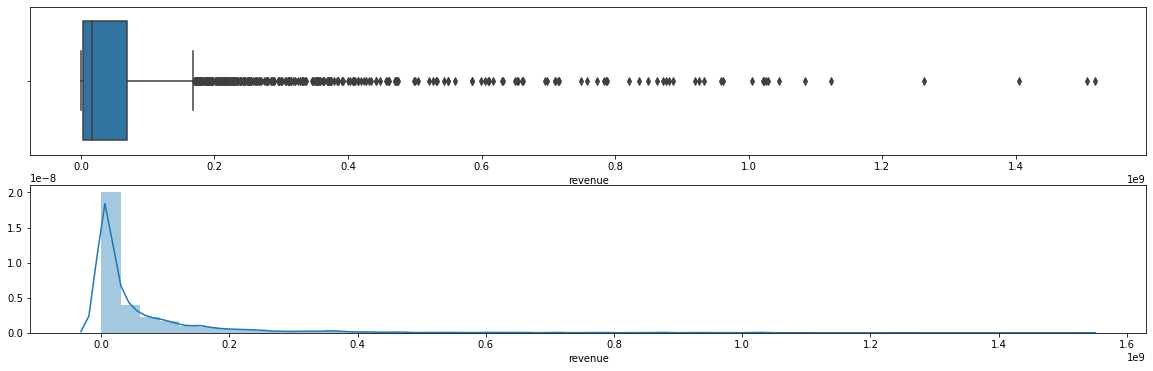

In [12]:
fig, ax = plt.subplots(2,1,figsize=(20,6))
sns.boxplot(train['revenue'],ax=ax[0])
sns.distplot(train.revenue,ax=ax[1])
plt.show()

### belongs_to_collection

In [13]:
train_meta.loc['belongs_to_collection'][:3]

nunique       422
NaN          2396
type       object
Name: belongs_to_collection, dtype: object

* id, name, poster path, backdrop path

In [14]:
list(train['belongs_to_collection'])[:5]

[[{'id': 313576,
   'name': 'Hot Tub Time Machine Collection',
   'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg',
   'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}],
 [{'id': 107674,
   'name': 'The Princess Diaries Collection',
   'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg',
   'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}],
 {},
 {},
 {}]

In [15]:
train['collection_name']=train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)
test['collection_name']=test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

In [16]:
print('collection 종류 :',train['collection_name'].nunique()-1)

collection 종류 : 422


In [17]:
list(train['collection_name'].unique())[:5]

['Hot Tub Time Machine Collection',
 'The Princess Diaries Collection',
 0,
 'The Muppet Collection',
 'Rocky Collection']

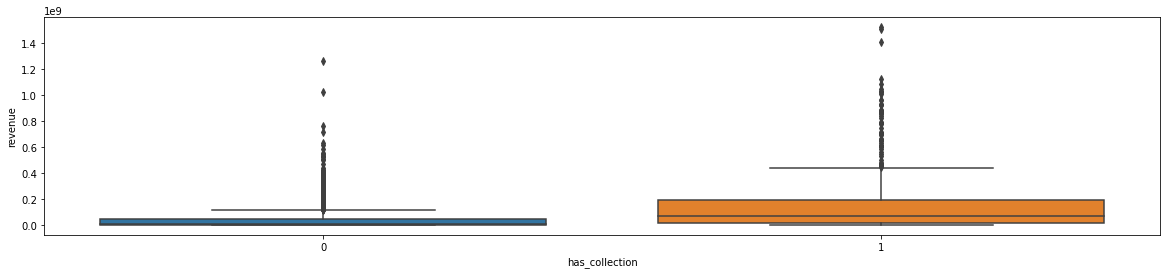

In [18]:
plt.figure(figsize=(20,4))
sns.boxplot(x='has_collection', y='revenue', data=train);

## budget

In [19]:
train_meta.loc['budget']

nunique            406
NaN                  0
type             int64
max            3.8e+08
min                  0
mean       2.25313e+07
std        3.70261e+07
Name: budget, dtype: object

* collection_name별 예산

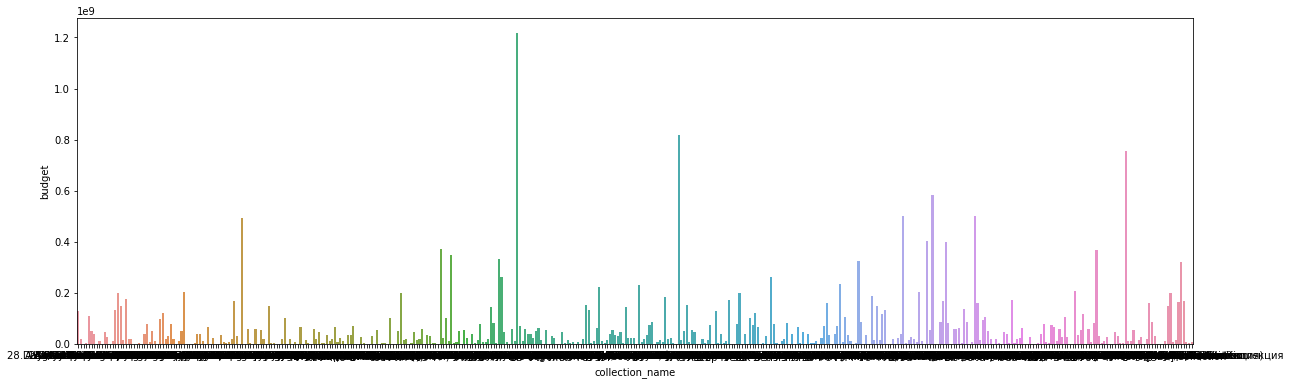

In [20]:
temp=train[['collection_name','budget','revenue']]
temp=temp[temp['collection_name'].notna()].reset_index(drop=True)
temp=temp.groupby('collection_name').sum().reset_index()
plt.figure(figsize=(20,6))
sns.barplot(data=temp.drop(0), x='collection_name', y='budget',ci=None)
plt.show()

* 예산 기준 내림차순

In [21]:
temp.drop(0).sort_values('budget', ascending=False)

,collection_name,budget,revenue
167,James Bond Collection,1216200000,4835896971
228,Pirates of the Caribbean C...,820000000,2661725026
397,Transformers Collection,755000000,3274696147
324,The Dark Knight Collection,585000000,2463716216
340,The Hobbit Collection,500000000,1979503568
...,...,...,...
110,El pico - Colección,0,2264522
111,Elektra Luxx Collection,0,10
298,Swamp Thing Collection,0,192816
113,Enter the Ninja Collection,0,13168027


* collection_name별 수익률
> 수익률 = (수익-예산) / 예산

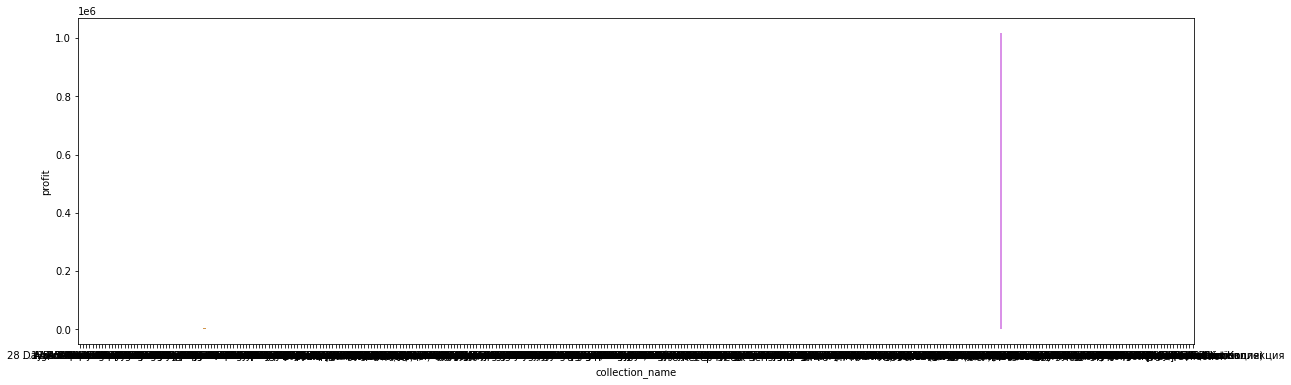

In [22]:
temp['profit']=(temp['revenue']-temp['budget'])/temp['budget']
temp=temp[temp['budget']!=0]
plt.figure(figsize=(20,6))
sns.barplot(data=temp.drop(0), x='collection_name', y='profit',ci=None)
plt.show()

In [23]:
temp.drop(0).sort_values('profit', ascending=False)

,collection_name,budget,revenue,profit
347,The Karate Kid Collection,113,115103979,1.018618e+06
51,Blair Witch Collection,60000,248000000,4.132333e+03
249,Recep İvedik Serisi,500000,154851495,3.087030e+02
338,The Hills Have Eyes (Origi...,230000,25000000,1.076957e+02
49,Billy Jack Collection,360000,36000000,9.900000e+01
...,...,...,...,...
117,Eye of the Dolphin Collection,2500000,71904,-9.712384e-01
143,Hatchet Collection,2500000,52604,-9.789584e-01
318,The Boondock Saints Collec...,6000000,30471,-9.949215e-01
399,Tulse Luper,10000000,25800,-9.974200e-01


* 예산의 분포 및 예산과 수익의 관계

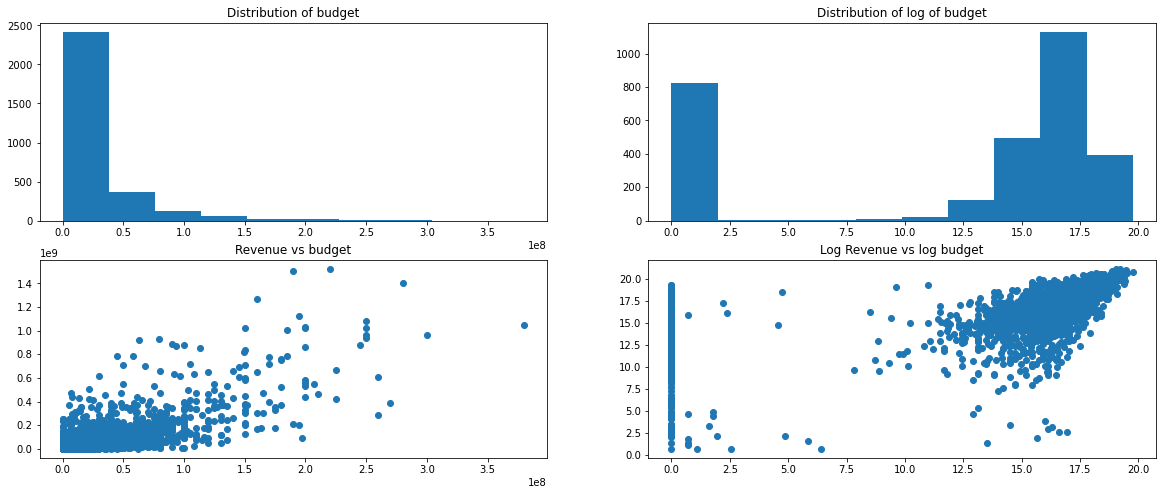

In [24]:
train['log_revenue'] = np.log1p(train['revenue'])
fig, ax = plt.subplots(figsize = (20, 8))
plt.subplot(2, 2, 1)
plt.hist(train['budget'])
plt.title('Distribution of budget')
plt.subplot(2, 2, 2)
plt.hist(np.log1p(train['budget']))
plt.title('Distribution of log of budget')
plt.subplot(2, 2, 3)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget')
plt.subplot(2, 2, 4)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget')
plt.show()

In [25]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

## genres

In [26]:
train_meta.loc['genres'][:3]

nunique       872
NaN             7
type       object
Name: genres, dtype: object

In [27]:
list(train['genres'])[:5]

[[{'id': 35, 'name': 'Comedy'}],
 [{'id': 35, 'name': 'Comedy'},
  {'id': 18, 'name': 'Drama'},
  {'id': 10751, 'name': 'Family'},
  {'id': 10749, 'name': 'Romance'}],
 [{'id': 18, 'name': 'Drama'}],
 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}],
 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]]

* value_counts

In [28]:
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [29]:
# 장르 개수
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)

# 장르 이름
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Top 15 장르 존재 여부
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)

# test
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

* 영화의 장르 개수별 수익

Text(0.5, 1.0, 'Revenue for different number of genres in the film')

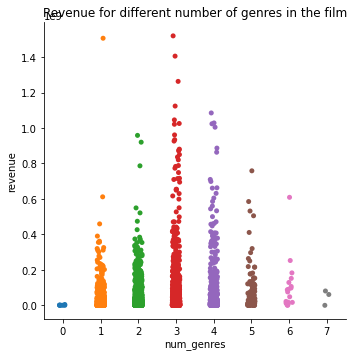

In [30]:
sns.catplot(x='num_genres', y='revenue', data=train)
plt.title('Revenue for different number of genres in the film')

* 장르별 수익 바이올린 플롯

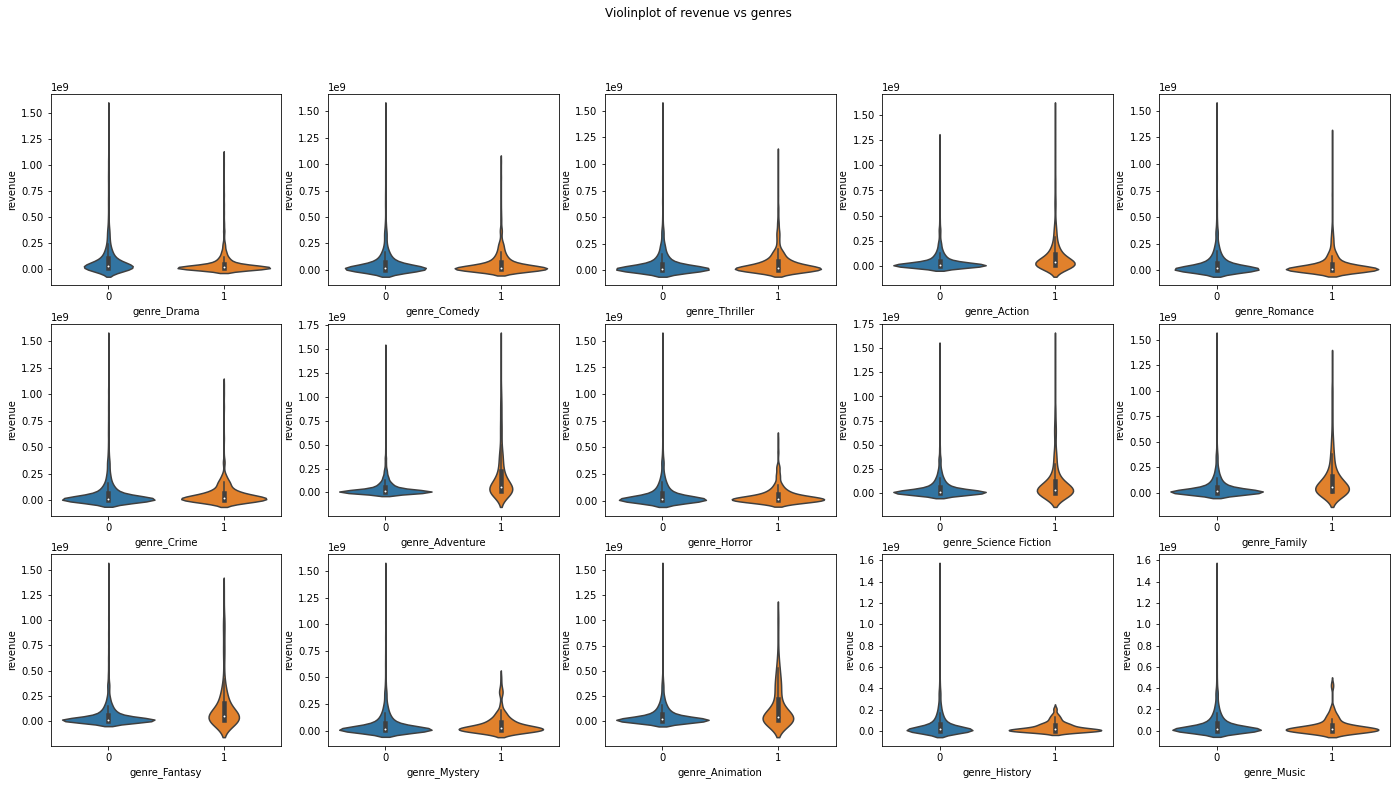

In [31]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## Homepage

In [32]:
train_meta.loc['homepage'][:3]

nunique       941
NaN          2054
type       object
Name: homepage, dtype: object

In [33]:
list(train['homepage'])[:7]

[nan,
 nan,
 'http://sonyclassics.com/whiplash/',
 'http://kahaanithefilm.com/',
 nan,
 nan,
 'http://www.thepossessionmovie.com/']

In [34]:
# 홈페이지 존재 여부
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

* 홈페이지 존재 여부에 따른 수익 분포
> 1 : 존재
> 홈페이지가 있는 영화가 대체로 수익이 높다.

<Figure size 1440x360 with 0 Axes>

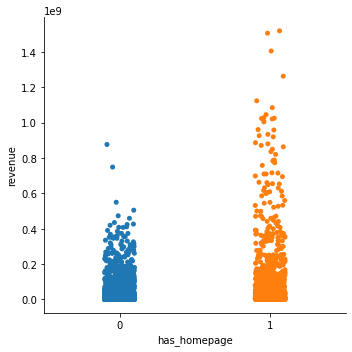

In [35]:
plt.figure(figsize=(20,5))
sns.catplot(x='has_homepage', y='revenue', data=train)
plt.show()

## original_language

In [36]:
train_meta.loc['original_language'][:3]

nunique        36
NaN             0
type       object
Name: original_language, dtype: object

* 언어별 수익 분포

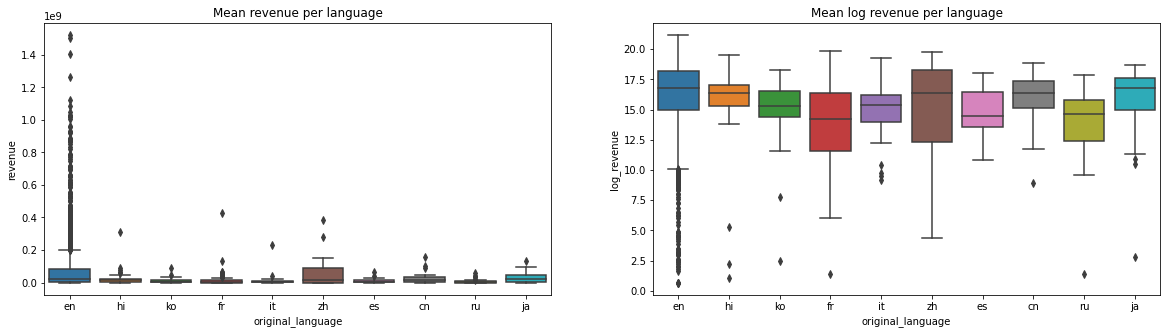

In [37]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

## original_title

In [38]:
train_meta.loc['original_title'][:3]

nunique      2975
NaN             0
type       object
Name: original_title, dtype: object

In [39]:
train['original_title']

0              Hot Tub Time Machine 2
1       The Princess Diaries 2: Ro...
2                            Whiplash
3                             Kahaani
4                                마린보이
                    ...              
2995                          Chasers
2996                      Vi är bäst!
2997          The Long Kiss Goodnight
2998                 Along Came Polly
2999                        Abduction
Name: original_title, Length: 3000, dtype: object

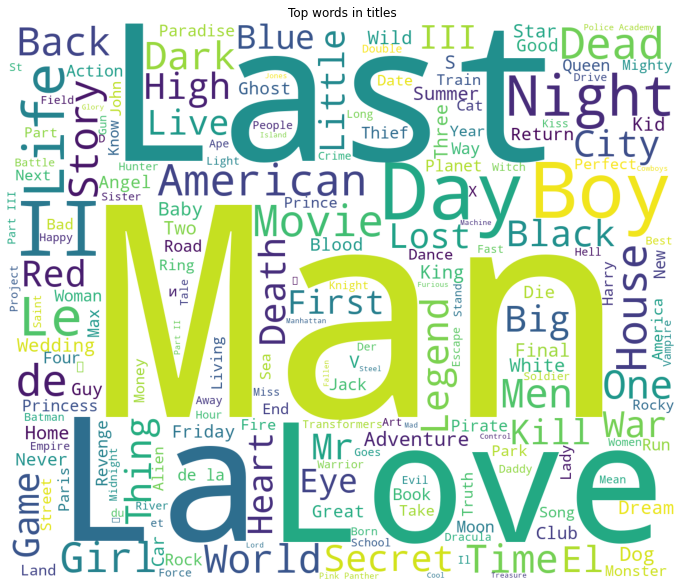

In [40]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

## overview

In [41]:
train_meta.loc['overview'][:3]

nunique      2992
NaN             8
type       object
Name: overview, dtype: object

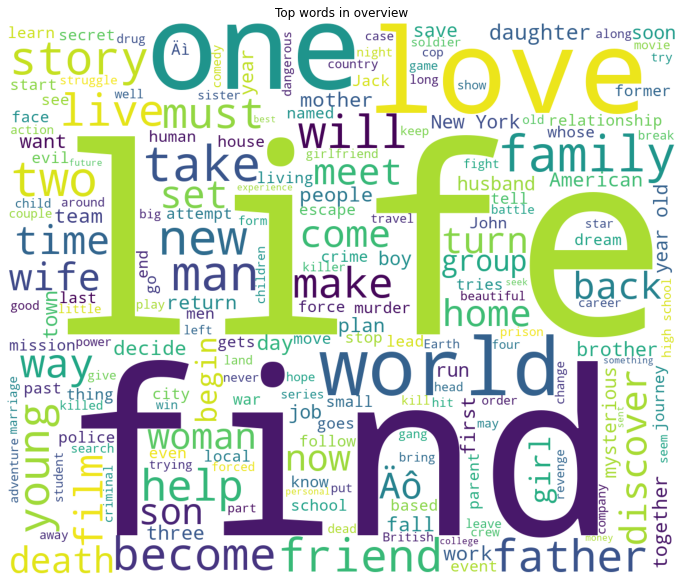

In [42]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

* eli5를 통한 중요 단어 찾기

In [43]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5,stop_words='english')

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

## popularity

In [44]:
train_meta.loc['popularity']

nunique       2999
NaN              0
type       float64
max        294.337
min          1e-06
mean       8.46327
std         12.104
Name: popularity, dtype: object

* 인기에 따른 수익 분포

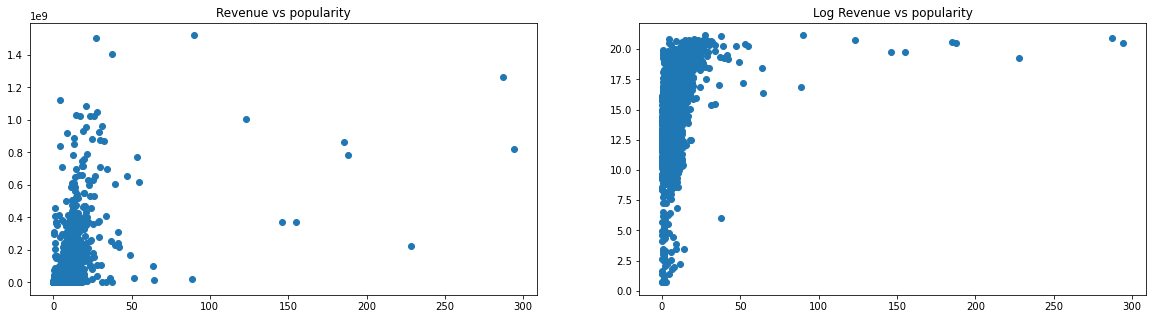

In [45]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity')
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'])
plt.title('Log Revenue vs popularity')
plt.show()

* collection_name별 인기 평균
> 조회수, 영화 평점 등으로 추측

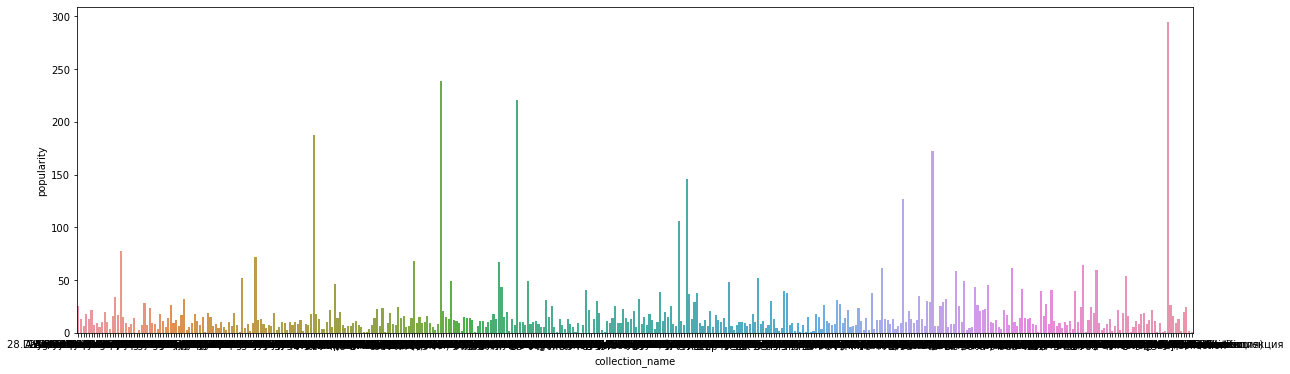

In [46]:
temp=train[['collection_name','popularity','revenue']]
temp=temp[temp['collection_name'].notna()].reset_index(drop=True)
temp=temp.groupby('collection_name').sum().reset_index()
plt.figure(figsize=(20,6))
sns.barplot(data=temp.drop(0), x='collection_name', y='popularity',ci=None)
plt.show()

In [47]:
temp.drop(0).sort_values('popularity', ascending=False).head(10)

,collection_name,popularity,revenue
413,Wonder Woman Collection,294.337037,820580447
138,Guardians of the Galaxy Co...,238.622593,1636744770
167,James Bond Collection,220.539219,4835896971
90,Deadpool Collection,187.860492,783112979
324,The Dark Knight Collection,172.255180,2463716216
231,Planet of the Apes (Reboot...,146.161786,369907963
313,The Avengers Collection,127.267068,2924961604
228,Pirates of the Caribbean C...,106.578049,2661725026
17,Alien Collection,77.843207,610021801
68,Child's Play Collection,71.671978,151192394


## production_companies

In [48]:
train_meta.loc['production_companies'][:3]

nunique      2383
NaN           156
type       object
Name: production_companies, dtype: object

In [49]:
list(train['production_companies'])[:5]

[[{'name': 'Paramount Pictures', 'id': 4},
  {'name': 'United Artists', 'id': 60},
  {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}],
 [{'name': 'Walt Disney Pictures', 'id': 2}],
 [{'name': 'Bold Films', 'id': 2266},
  {'name': 'Blumhouse Productions', 'id': 3172},
  {'name': 'Right of Way Films', 'id': 32157}],
 {},
 {}]

* value_counts

In [50]:
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

* 제작사 빈도수 상위 10개

In [51]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_companies for i in j]).most_common(10)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61)]

In [52]:
# comanies 개수
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)

# production_companies 이름
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Top 30 회사 존재 여부
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

* 각 제작사별 수익 violin plot
> 높은 수익을 내는 제작사를 확인할 수 있다.

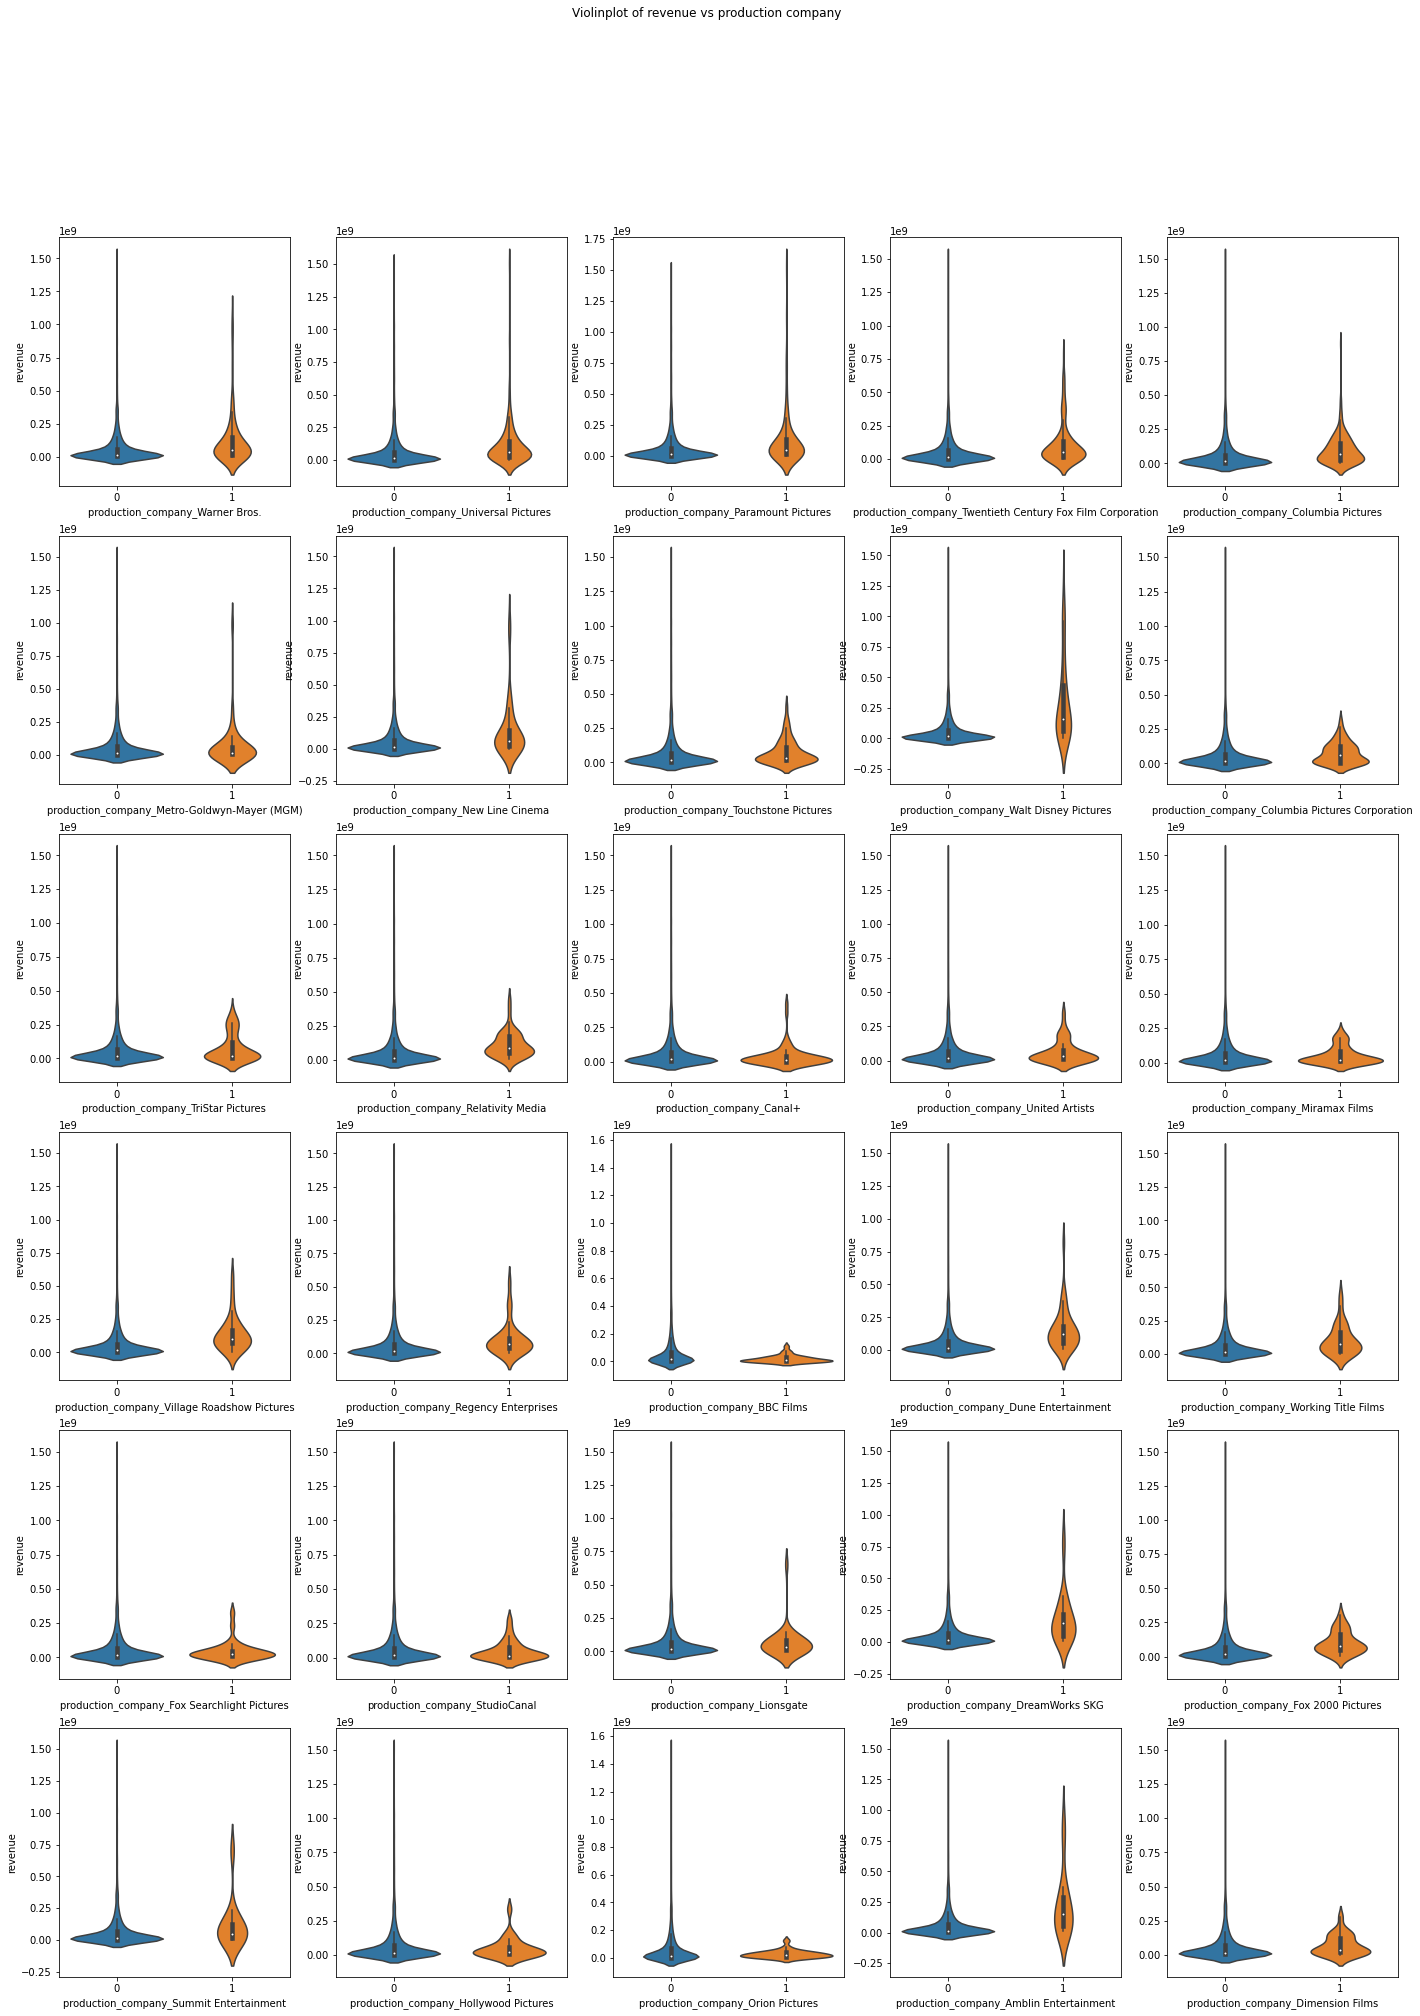

In [53]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## production_countries

In [54]:
train_meta.loc['production_countries'][:3]

nunique       321
NaN            55
type       object
Name: production_countries, dtype: object

In [55]:
list(train['production_countries'])[:5]

[[{'iso_3166_1': 'US', 'name': 'United States of America'}],
 [{'iso_3166_1': 'US', 'name': 'United States of America'}],
 [{'iso_3166_1': 'US', 'name': 'United States of America'}],
 [{'iso_3166_1': 'IN', 'name': 'India'}],
 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]]

* value_counts

In [56]:
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

* 제작국 빈도수 상위 10개

In [57]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(10)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58)]

In [58]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

* 각 제작 국가별 수익 violin plot
> 높은 수익을 내는 국가를 확인할 수 있다

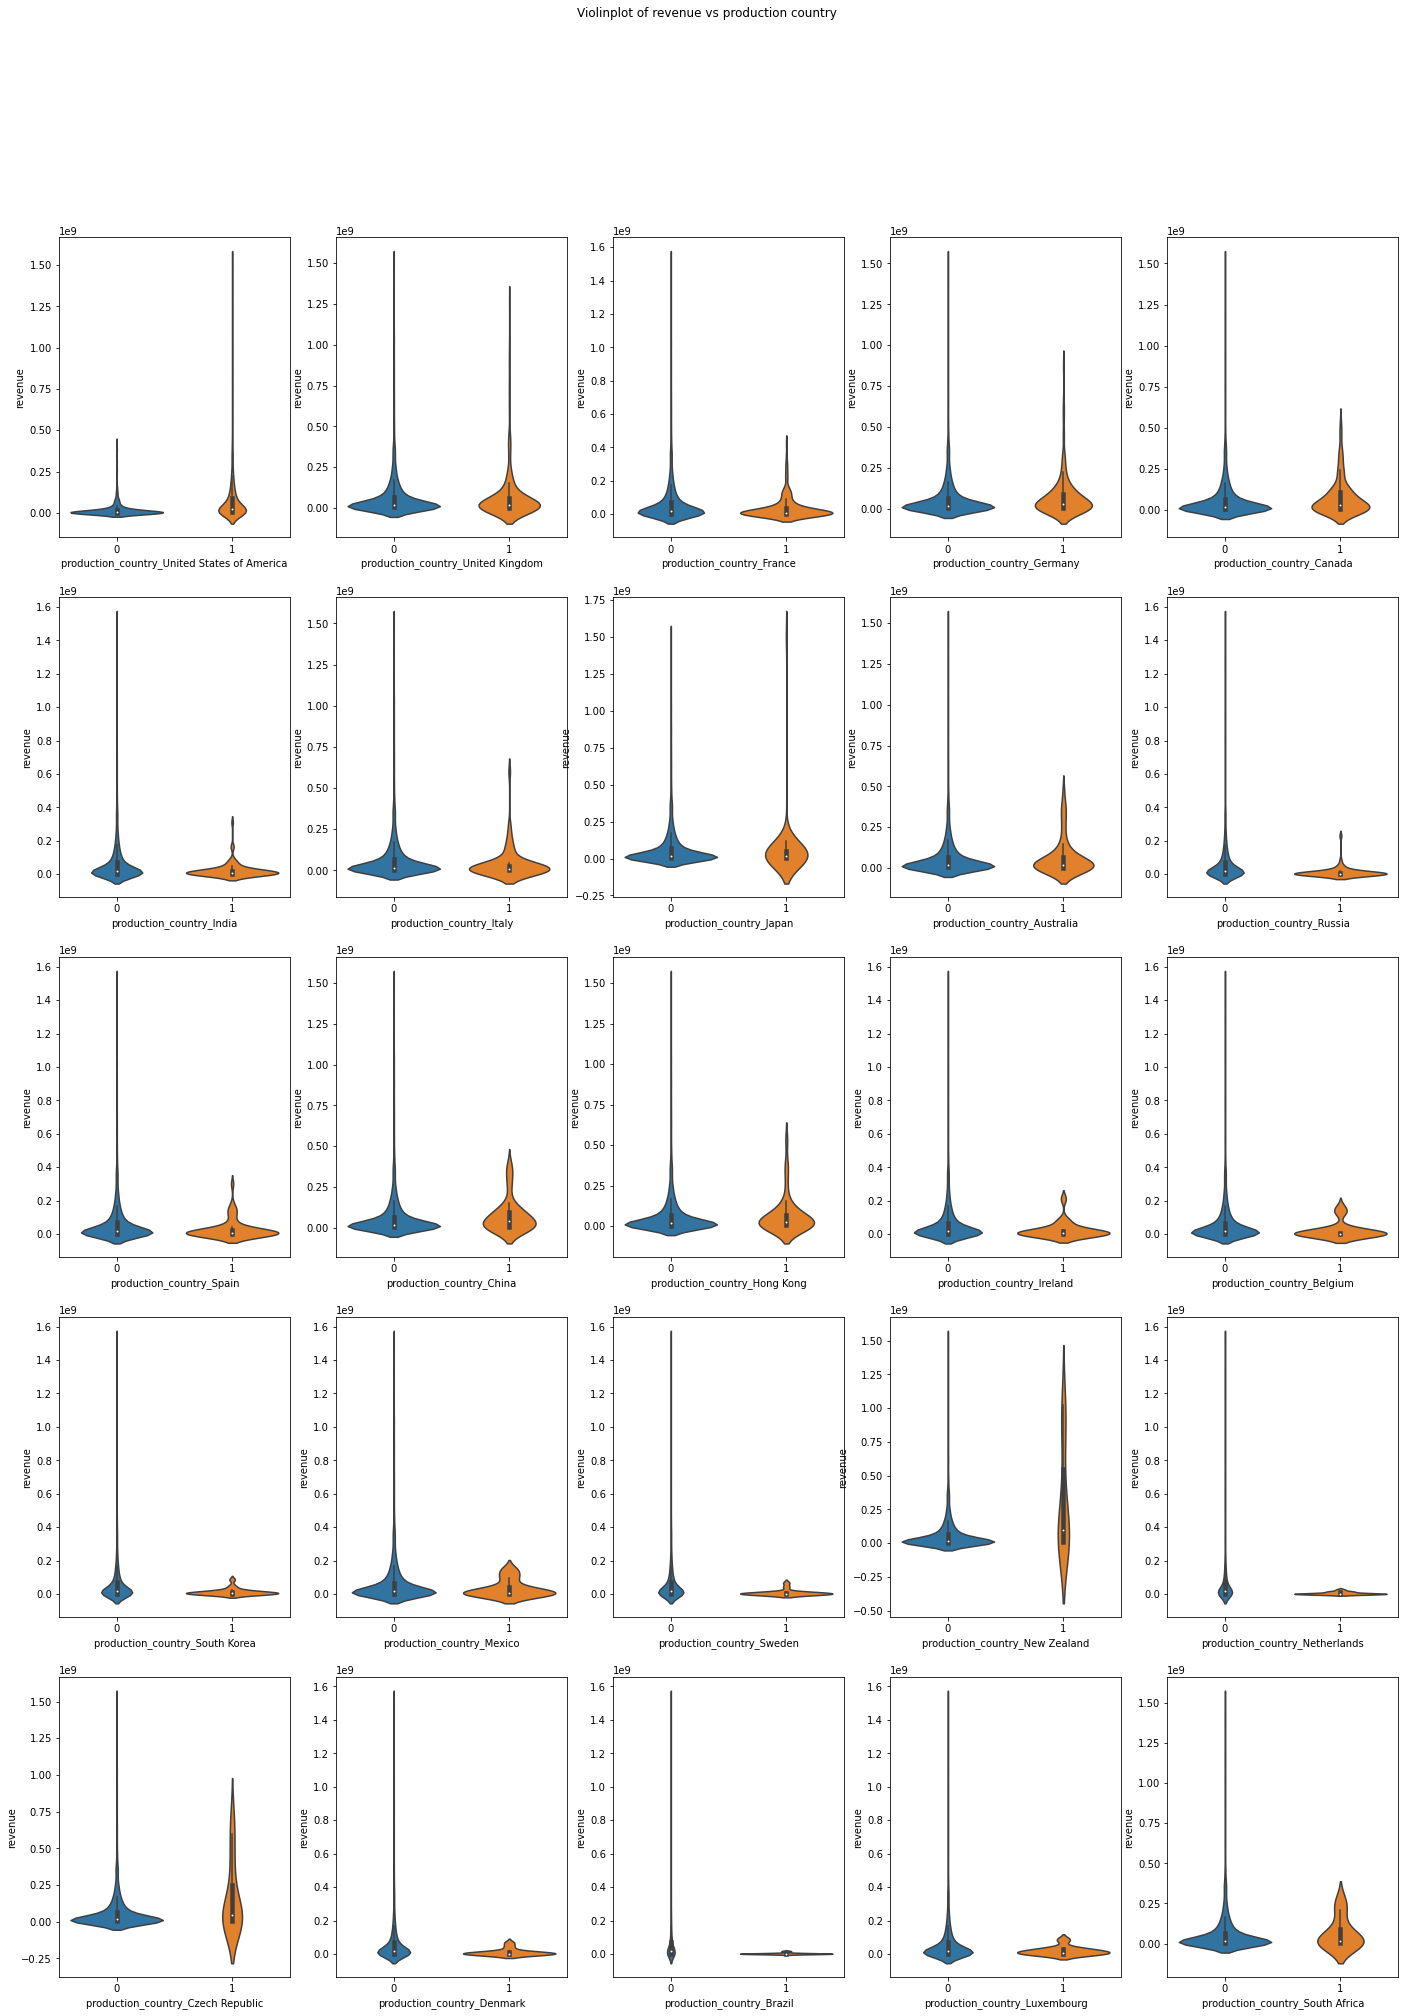

In [59]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## release_date

In [60]:
train_meta.loc['release_date'][:3]

nunique      2398
NaN             0
type       object
Name: release_date, dtype: object

In [61]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])
train = process_date(train)
test = process_date(test)

* train과 test 데이터 셋의 연도별 개봉 영화 개수

In [62]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year(train & test)",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

* 연도별 개봉 영화와 총 수익률

In [63]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

* 연도별 개봉 영화와 평균 수익률

In [64]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

* 개봉 요일별 수익
> 수·목요일에 높은 수익을 확인

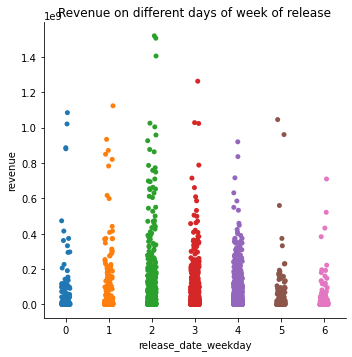

In [65]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

## Runtime

In [66]:
train_meta.loc['runtime']

nunique        139
NaN              2
type       float64
max            338
min              0
mean       107.857
std        22.0864
Name: runtime, dtype: object

* 상영시간 시간별 영화 분포와 상영시간과 수익·인기도 비교
> 특이점은 없다.

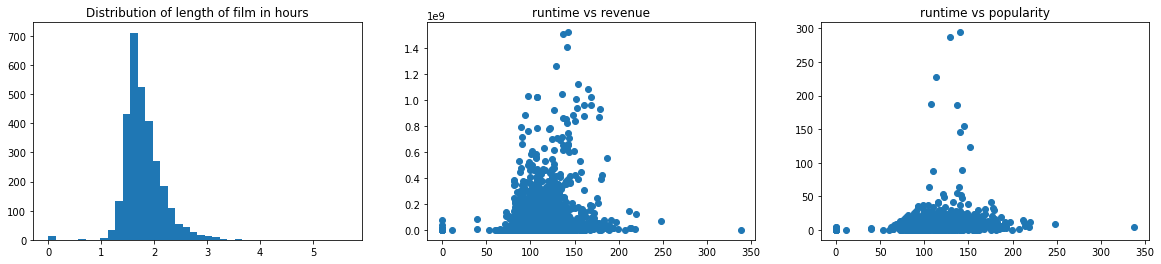

In [67]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0) / 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.title('runtime vs popularity');

## spoken_languages

In [68]:
train_meta.loc['spoken_languages'][:3]

nunique       401
NaN            20
type       object
Name: spoken_languages, dtype: object

* value_counts

In [69]:
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

* 영화 언어 상위 15개

In [70]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [71]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

## status

In [72]:
train_meta.loc['status'][:3]

nunique         2
NaN             0
type       object
Name: status, dtype: object

In [73]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

## tagline

In [74]:
train_meta.loc['tagline'][:3]

nunique      2400
NaN           597
type       object
Name: tagline, dtype: object

In [75]:
list(train['tagline'][:4])

['The Laws of Space and Time are About to be Violated.',
 "It can take a lifetime to find true love; she's got 30 days!",
 'The road to greatness can take you to the edge.',
 nan]

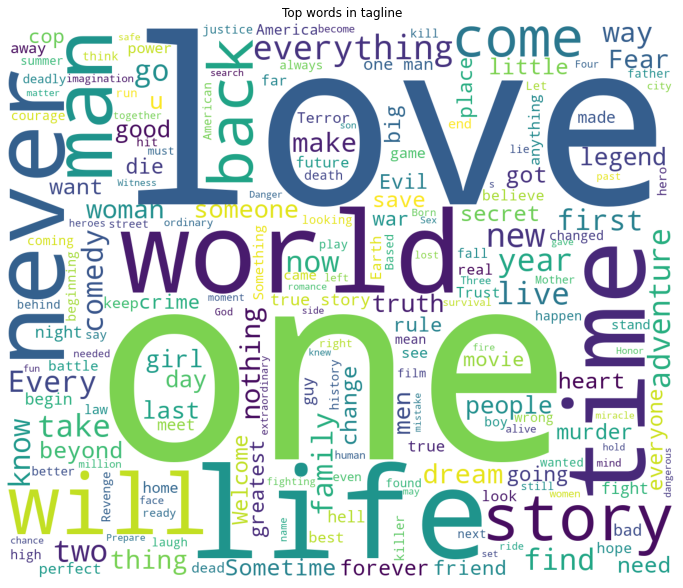

In [76]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

## Keywords

In [77]:
train_meta.loc['Keywords'][:3]

nunique      2648
NaN           276
type       object
Name: Keywords, dtype: object

In [78]:
list(train['Keywords'][:2])

[[{'id': 4379, 'name': 'time travel'},
  {'id': 9663, 'name': 'sequel'},
  {'id': 11830, 'name': 'hot tub'},
  {'id': 179431, 'name': 'duringcreditsstinger'}],
 [{'id': 2505, 'name': 'coronation'},
  {'id': 4263, 'name': 'duty'},
  {'id': 6038, 'name': 'marriage'},
  {'id': 13072, 'name': 'falling in love'}]]

* value_counts

In [79]:
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

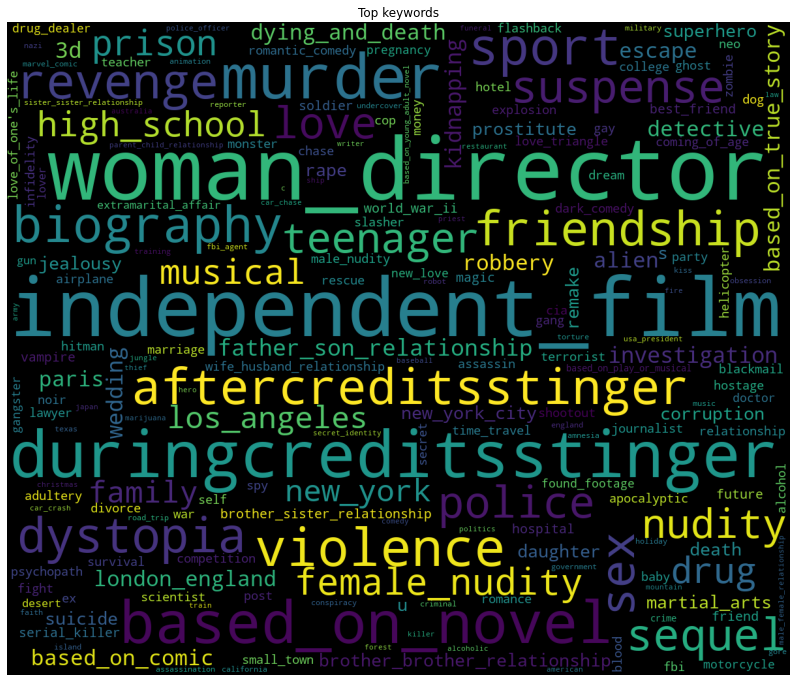

In [80]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

In [81]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

## cast

In [82]:
train_meta.loc['cast'][:3]

nunique      2975
NaN            13
type       object
Name: cast, dtype: object

In [83]:
list(train['cast'][:3])

[[{'cast_id': 4,
   'character': 'Lou',
   'credit_id': '52fe4ee7c3a36847f82afae7',
   'gender': 2,
   'id': 52997,
   'name': 'Rob Corddry',
   'order': 0,
   'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
  {'cast_id': 5,
   'character': 'Nick',
   'credit_id': '52fe4ee7c3a36847f82afaeb',
   'gender': 2,
   'id': 64342,
   'name': 'Craig Robinson',
   'order': 1,
   'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'},
  {'cast_id': 6,
   'character': 'Jacob',
   'credit_id': '52fe4ee7c3a36847f82afaef',
   'gender': 2,
   'id': 54729,
   'name': 'Clark Duke',
   'order': 2,
   'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'},
  {'cast_id': 7,
   'character': 'Adam Jr.',
   'credit_id': '52fe4ee7c3a36847f82afaf3',
   'gender': 2,
   'id': 36801,
   'name': 'Adam Scott',
   'order': 3,
   'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'},
  {'cast_id': 8,
   'character': 'Hot Tub Repairman',
   'credit_id': '52fe4ee7c3a36847f82afaf7',
   'gender': 2,
   'id': 54812,
   'name'

* value_counts

In [84]:
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

* 출연자 빈도 상위 15

In [85]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

* 이미지 불러오기 > 404 에러

In [86]:
# list_of_cast_names_url = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
# d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
# fig = plt.figure(figsize=(20, 12))
# for i, p in enumerate([j[0] for j in d]):
#     ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
#     im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
#     plt.imshow(im)
#     ax.set_title(f'{p[0]}')

* 성별 : 0 is unspecified, 1 is female, and 2 is male.

In [87]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

* 캐릭터 빈도 상위 15

In [88]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

In [89]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

## crew

In [90]:
train_meta.loc['crew'][:3]

nunique      2984
NaN            16
type       object
Name: crew, dtype: object

In [91]:
list(train['crew'][:3])

[[{'credit_id': '59ac067c92514107af02c8c8',
   'department': 'Directing',
   'gender': 0,
   'id': 1449071,
   'job': 'First Assistant Director',
   'name': 'Kelly Cantley',
   'profile_path': None},
  {'credit_id': '52fe4ee7c3a36847f82afad7',
   'department': 'Directing',
   'gender': 2,
   'id': 3227,
   'job': 'Director',
   'name': 'Steve Pink',
   'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
  {'credit_id': '5524ed25c3a3687ded000d88',
   'department': 'Writing',
   'gender': 2,
   'id': 347335,
   'job': 'Writer',
   'name': 'Josh Heald',
   'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
  {'credit_id': '5524ed2d925141720c001128',
   'department': 'Writing',
   'gender': 2,
   'id': 347335,
   'job': 'Characters',
   'name': 'Josh Heald',
   'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
  {'credit_id': '5524ed3d92514166c1004a5d',
   'department': 'Production',
   'gender': 2,
   'id': 57822,
   'job': 'Producer',
   'name': 'Andrew Panay',
   'profile_path': N

* value_counts

In [92]:
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

* crew name 빈도 상위 15

In [93]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

* 이미지 불러오기 > 404 에러

In [94]:
# list_of_crew_names_url = list(train['crew'].apply(lambda x: [(i['name'], i['profile_path'], i['job']) for i in x] if x != {} else []).values)
# d = Counter([i for j in list_of_crew_names_url for i in j]).most_common(16)
# fig = plt.figure(figsize=(20, 16))
# for i, p in enumerate([j[0] for j in d]):
#     ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
#     if p[1]:
#         im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
#     else:
#         im = Image.new('RGB', (5, 5))
#     plt.imshow(im)
#     ax.set_title(f'Name: {p[0]} \n Job: {p[2]}')

* job 빈도 상위 15

In [95]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

* 성별 : 0 is unspecified, 1 is female, and 2 is male.

In [96]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

* department 빈도 상위 15

In [97]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [98]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

* 소속된 crew의 수에 따른 수익 분포

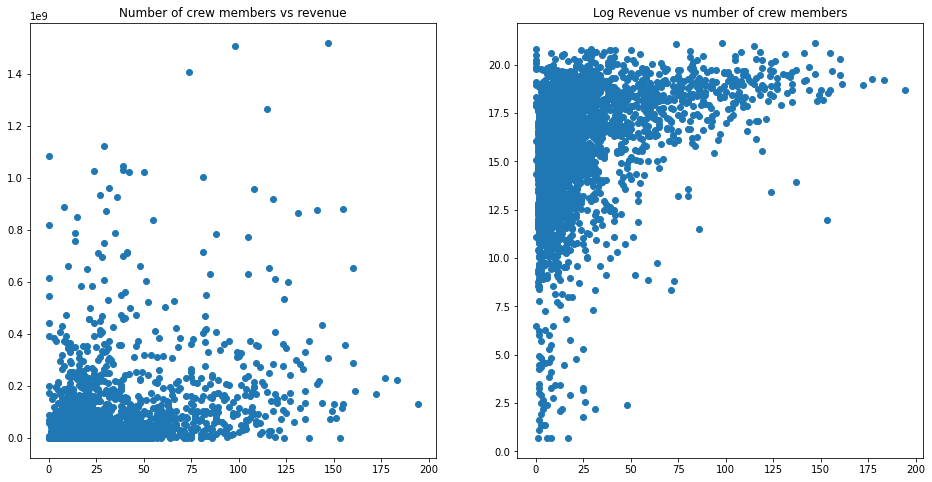

In [99]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_crew'], train['log_revenue'])
plt.title('Log Revenue vs number of crew members');

* 각 직업에 해당되는 수에 따른 수익 분포

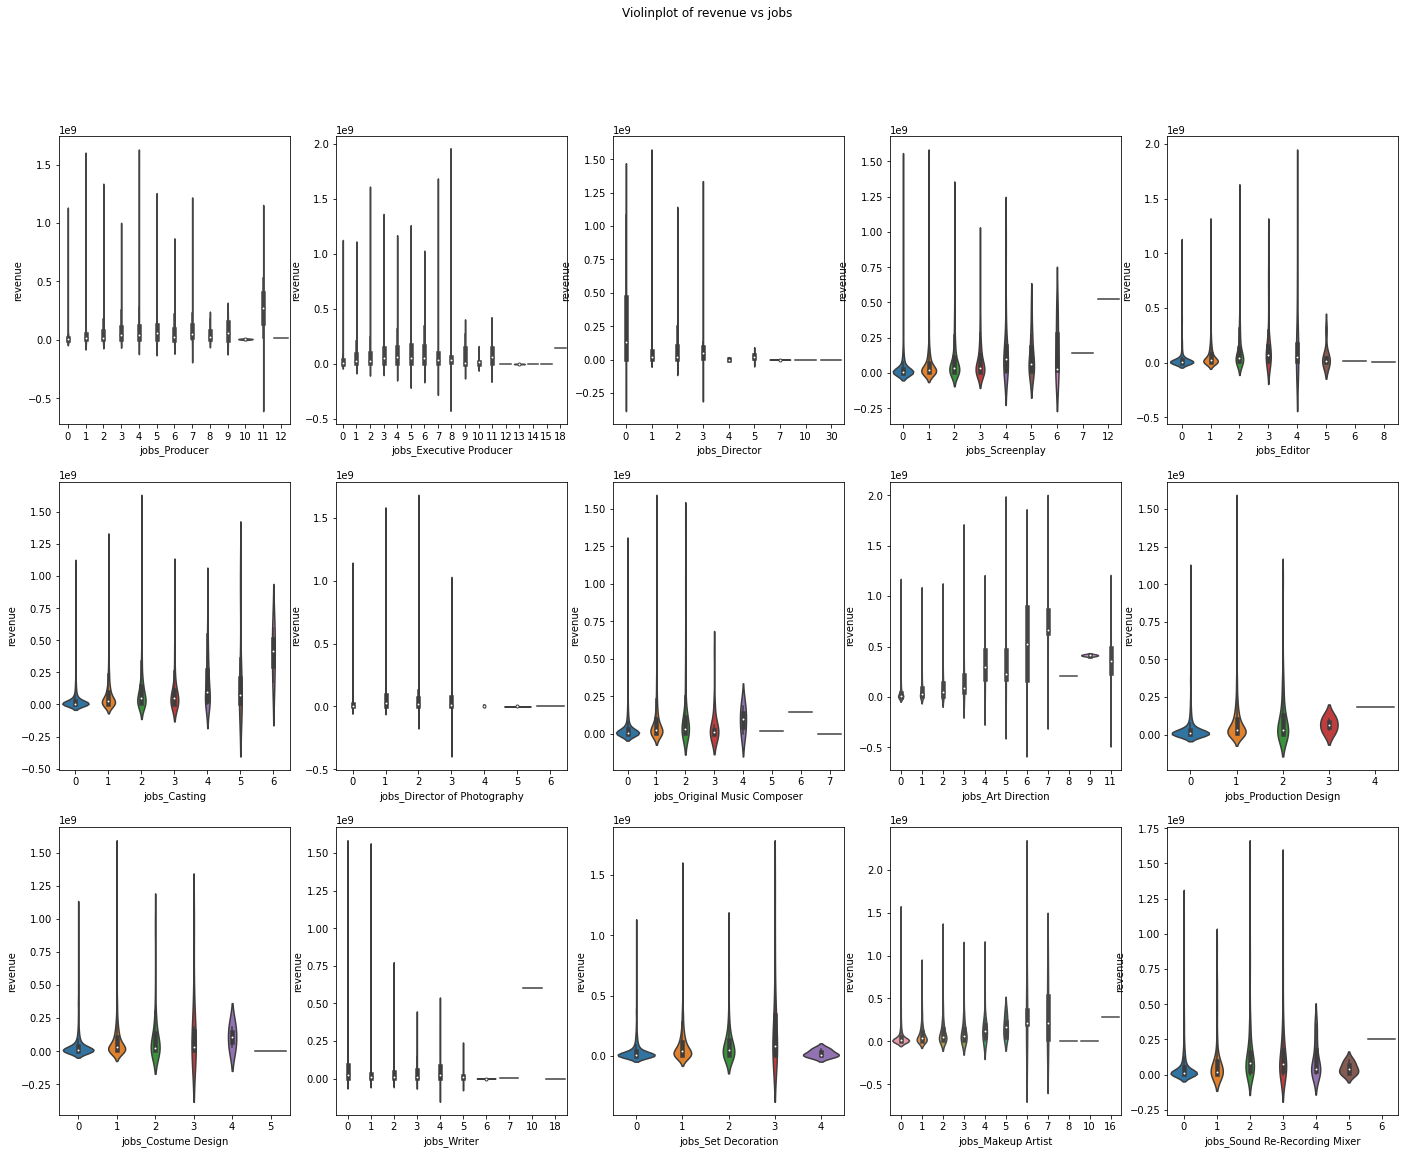

In [100]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);